## PCA Pipeline Exploration
I tidied up a few things from the EDA_pipeline file
4/5/2020

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
#Get CSV's into memory
df = pd.read_csv("2019_all_delta_extra.csv")
team_runs = {}

def get_teams():
    teams = [item.strip() for item in open("all_teams.txt",'r')]
    return teams

teams = get_teams()

df

,Date,Home_Win,Home,Away,Win Percent Delta,Streak Delta,Run Scored Delta,Run Allowed Delta,Run Delta Delta,Run Delta Percent Delta,Win Total Delta
0,thursday mar 28,W,OAK,LAA,0.000000,-2,11,14,-3,0.7857,0
1,friday mar 29,L,OAK,LAA,0.333333,2,15,10,5,1.0714,1
2,saturday mar 30,W,OAK,LAA,-0.250000,-2,11,14,-3,-0.1500,0
3,sunday mar 31,W,OAK,LAA,0.066667,2,13,12,1,0.1545,1
4,monday apr 1,W,SEA,LAA,0.583333,4,39,23,16,0.6214,4
...,...,...,...,...,...,...,...,...,...,...,...
2424,sunday apr 14,L,NYY,CHW,0.120879,2,12,-29,41,0.5459,2
2425,thursday jun 13,W,CHW,NYY,-0.136364,2,-75,50,-125,-0.4098,-9
2426,friday jun 14,W,CHW,NYY,-0.119403,4,-74,49,-123,-0.3972,-8
2427,saturday jun 15,L,CHW,NYY,-0.102941,6,-66,41,-107,-0.3382,-7


In [3]:
X = df.loc[:,df.columns[4:]].values
y = df.loc[:,df.columns[1]].values

In [4]:
#create win/loss mask
wins = df.loc[:,'Home_Win'] == 'W'
losses = df.loc[:,'Home_Win'] != 'W'

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
le = LabelEncoder()
y_label = le.fit_transform(y)
le.transform(['W','L'])

array([1, 0], dtype=int64)

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_transform, y_label, 
                     test_size=0.25,
                     stratify=y_label,
                     random_state=1)

In [7]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array(X_transform)

# calculate the mean of each column
M = mean(A.T, axis=1)

# center columns by subtracting column means
C = A - M

# calculate covariance matrix of centered matrix. This is how much each columns varies with other columns
V = cov(C.T)

# eigendecomposition of covariance matrix.  The larger the eigenvalue, the more it matters
values, vectors = eig(V)
print(f'Eigenvalues: {values}')

# project data using the covariance matrix and the eigenvectors
P = vectors.T.dot(C.T)

xval = np.array([item[0] for item in P.T])
yval = np.array([item[1] for item in P.T])

Eigenvalues: [ 4.37076290e+00  8.71837589e-01  6.88902588e-01  7.84865838e-01
  2.35265262e-01  5.12488495e-02 -3.71637686e-16]


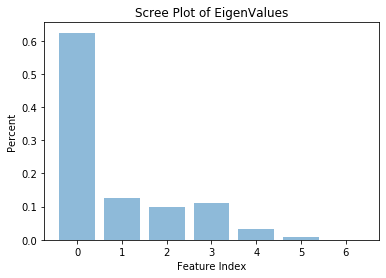

In [8]:
def create_scree(vector):
    total = sum(vector)
    percent = vector/total
    return percent

import matplotlib.pyplot as plt

plt.title('Scree Plot of EigenValues')
plt.ylabel('Percent')
plt.xlabel('Feature Index')
plt.bar([x for x in range(len(values))], create_scree(values), align='center', alpha=0.5)
plt.show()

In [9]:
#confirming results with sklearn package
pca = PCA(n_components=5, svd_solver='full')
pca.fit(X_transform)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.62413764 0.12449695 0.11207753 0.09837414 0.03359549]
[103.01559266  46.0089303   43.65380001  40.89811099  23.90029408]


### Comparing the results of Pipeline with Make_pipeline... small variation which I find odd

In [10]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.5904605263157895

In [18]:
scores = cross_val_score(estimator=pipe,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.62962963 0.61728395 0.56378601 0.52263374 0.52263374 0.58024691
 0.60082305 0.6255144  0.5473251  0.6446281 ]
CV accuracy: 0.585 +/- 0.043


In [22]:
# no value for PCA components
pipe_lr = make_pipeline(PCA(),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr.fit(X_train,y_train)
print(f'PCA components unset score: {round(pipe_lr.score(X_test,y_test),3)}')

pipe_lr2 = make_pipeline(PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr2.fit(X_train,y_train)
print(f'PCA components set to 2 score: {round(pipe_lr2.score(X_test,y_test),3)}')

PCA components unset score: 0.592
PCA components set to 2 score: 0.574


In [23]:
#PCA unlimited
scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.62962963 0.61728395 0.56378601 0.52263374 0.52263374 0.58024691
 0.60082305 0.6255144  0.5473251  0.6446281 ]
CV accuracy: 0.585 +/- 0.043


In [24]:
#PCA with 2
scores = cross_val_score(estimator=pipe_lr2,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.61728395 0.62139918 0.58024691 0.52674897 0.52263374 0.59670782
 0.63374486 0.62962963 0.58436214 0.63636364]
CV accuracy: 0.595 +/- 0.040


### Grid search indicates that n components of 2 should be best, but when I don't set that variable in the pipeline it actually performs better

Best parameter (CV score=0.599):
{'logistic__C': 21.54434690031882, 'pca__n_components': 2}


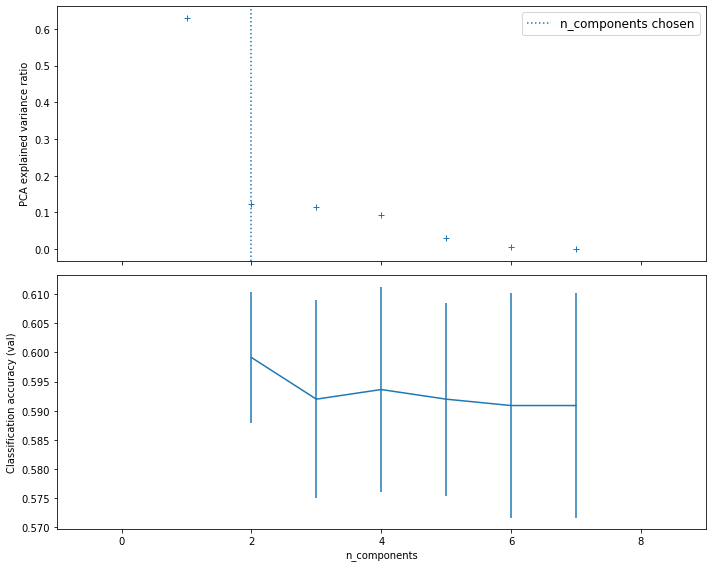

In [12]:
from sklearn.model_selection import GridSearchCV

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [2, 3, 4, 5, 6, 7],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)


fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 9)

plt.tight_layout()
plt.show()

## There is little separation of the data using PCA

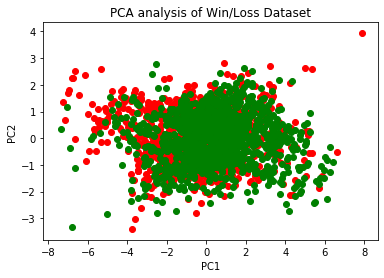

In [13]:
import matplotlib.pyplot as plt

#plot loses as red and wins as green
plt.scatter(xval[losses], yval[losses], color='red')                            
plt.scatter(xval[wins], yval[wins], color='green')

plt.title('PCA analysis of Win/Loss Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig("Images\\PCA_7.png")
plt.show()

## PCA --> Logistic Pipeline

In [16]:
pipe_lr = make_pipeline(PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.5740131578947368

## This is the best result I have gotten... even better than the NN

In [15]:
#sklearn has a cross validator built in so we don't need to loop through things manuially
scores = cross_val_score(estimator=pipe_lr,
                         X=X_transform,
                         y=y_label,
                         cv=10,
                         n_jobs=1)
#print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.595 +/- 0.040


This is about 4% higher than the other pipeline, and unlike the NN it's accuracy does not change with each iteration

# PCA -> NN Pipeline

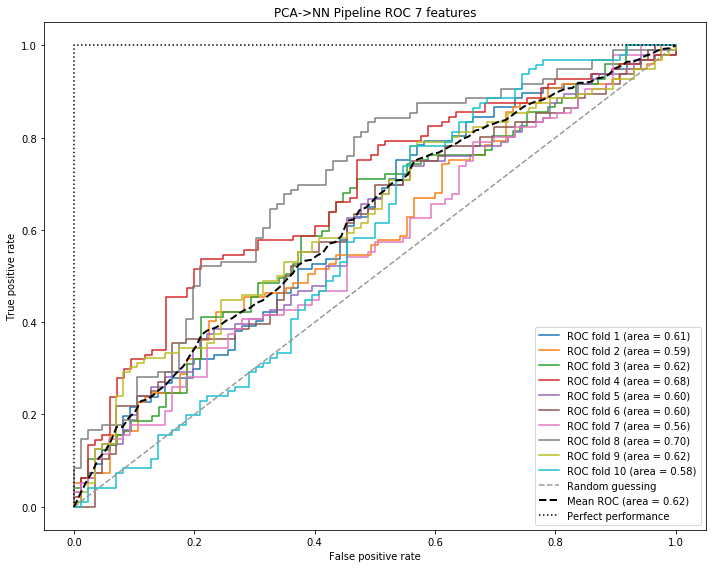

In [25]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
                    
# here we are selecting only 2 features from the dataset
X_train2 = X_train
#[:, [0,2,3]]
    
#You can set the cross validator here with the number of splits
cv = list(StratifiedKFold(n_splits=10).split(X_train, y_train))

fig = plt.figure(figsize=(10, 8))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    #Xtrain2 is used here for the fit, using only the features chosen above.  If you use the Xtrain data it will get 100%
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("PCA->NN Pipeline ROC 7 features")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('Images\\ROC_7.png')
plt.show()

## NN results

In [17]:
#sklearn has a cross validator built in so we don't need to loop through things manuially
for i in range(0,10):
    scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.584 +/- 0.028
CV accuracy: 0.578 +/- 0.032
CV accuracy: 0.589 +/- 0.041
CV accuracy: 0.588 +/- 0.026
CV accuracy: 0.582 +/- 0.028
CV accuracy: 0.590 +/- 0.034
CV accuracy: 0.584 +/- 0.034
CV accuracy: 0.586 +/- 0.030
CV accuracy: 0.591 +/- 0.040
CV accuracy: 0.583 +/- 0.033


The PCA-> NN achieves ~58% accuracy

# Naive Bayes


In [30]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f'Accuracy: {round(1-((y_test != y_pred).sum()/X_test.shape[0]),3)}')
gnb.score(X_test, y_test)

Number of mislabeled points out of a total 608 points : 262
Accuracy: 0.569


0.569078947368421

In [31]:
scores = cross_val_score(estimator=gnb,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.58847737 0.61316872 0.57201646 0.51851852 0.5308642  0.59259259
 0.59670782 0.60082305 0.55967078 0.62396694]
CV accuracy: 0.580 +/- 0.033


### Putting Naive Bayes into a pipeline with PCA does not do anything for the final results, unsurprisingly

In [32]:
pipe_lr = make_pipeline(PCA(),
                        GaussianNB())
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)

0.5838815789473685

In [22]:
scores = cross_val_score(estimator=gnb,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.58847737 0.61316872 0.57201646 0.51851852 0.5308642  0.59259259
 0.59670782 0.60082305 0.55967078 0.62396694]
CV accuracy: 0.580 +/- 0.033


## Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=3, 
                                    random_state=1)
tree_model.fit(X_train, y_train)
scores = cross_val_score(estimator=tree_model,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.6090535  0.60493827 0.56790123 0.52674897 0.51440329 0.58024691
 0.61728395 0.58024691 0.56378601 0.61983471]
CV accuracy: 0.578 +/- 0.035


### Putting the PCA into the decision tree did, however, result in a slight improvement (probably negligible)

In [29]:
pipe_lr = make_pipeline(PCA(),
                        DecisionTreeClassifier(criterion='gini',
                                               max_depth=3,
                                               random_state=1))
pipe_lr.fit(X_train, y_train)
scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.62962963 0.60082305 0.55555556 0.55967078 0.56378601 0.57201646
 0.58847737 0.56378601 0.55967078 0.61570248]
CV accuracy: 0.581 +/- 0.025


## PCA --> NN

In [27]:
pipe_lr = make_pipeline(PCA(n_components=2),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
pipe_lr.fit(X_train, y_train)
scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

0.5888157894736842

## LDA --> NN


In [34]:
pipe_lr = make_pipeline(LDA(),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
pipe_lr.fit(X_train, y_train)
for i in range(5):
    scores = cross_val_score(estimator=pipe_lr,
                                 X=X_transform,
                                 y=y_label,
                                 cv=10,
                                 n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.581 +/- 0.032
CV accuracy: 0.575 +/- 0.035
CV accuracy: 0.577 +/- 0.037
CV accuracy: 0.576 +/- 0.041
CV accuracy: 0.583 +/- 0.036


## LDA

In [33]:
lda = LDA()
lda.fit(X_train,y_train)
scores = cross_val_score(estimator=lda,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

0.5855263157894737